In [ ]:
from datasets import load_dataset
from itertools import chain
import pandas as pd

# splits = ["2020", "2021", "2022", "2023", "2024", "2025", "2026"]
splits = ["2020"]

columns_to_keep = [
    'submission_id',
    'year',
    'openreview_link',
    'pdf_download_link',
    'title',
    'original_abstract',
    'original_reviews',
    'normalized_reviews',
    'original_metareview',
    'technical_indicators'
]

streams = [
    load_dataset(
        "skonan/iclr-reviews-2020-2026",
        split=s,
        streaming=True
    )
    for s in splits
]

df_with_rebuttal = pd.DataFrame(
    {col: row.get(col) for col in columns_to_keep}
    for row in chain.from_iterable(streams)
)

df_with_rebuttal.head() # dataframe from auto reviewer

,submission_id,year,openreview_link,pdf_download_link,title,original_abstract,original_reviews,normalized_reviews,original_metareview,technical_indicators
0,ryxz8CVYDH,2020,https://openreview.net/forum?id=ryxz8CVYDH,https://openreview.net/pdf/07a4b4b413b37f2c43c...,Learning to Learn by Zeroth-Order Oracle,"In the learning to learn (L2L) framework, we c...","[{""rating"": ""6: Weak Accept"", ""review"": ""The p...","[""{\""summary\"":\""The paper introduces a zeroth...","{""decision"": ""Accept (Poster)"", ""comment"": ""Th...","{""binary_decision"": ""accept"", ""specific_decisi..."
1,ryxyCeHtPB,2020,https://openreview.net/forum?id=ryxyCeHtPB,https://openreview.net/pdf/84d13359f1520c521f1...,"Pay Attention to Features, Transfer Learn Fast...",Deep convolutional neural networks are now wid...,"[{""rating"": ""6: Weak Accept"", ""review"": "" This...","[""{\""summary\"":\""The paper introduces Attentiv...","{""decision"": ""Accept (Poster)"", ""comment"": ""Th...","{""binary_decision"": ""accept"", ""specific_decisi..."
2,ryxtWgSKPB,2020,https://openreview.net/forum?id=ryxtWgSKPB,https://openreview.net/pdf/e90a912a0f6b4596f6b...,Quantum Optical Experiments Modeled by Long Sh...,We demonstrate how machine learning is able to...,"[{""rating"": ""3: Weak Reject"", ""review"": ""This ...","[""{\""summary\"":\""The paper proposes using mach...","{""decision"": ""Reject"", ""comment"": ""The paper p...","{""binary_decision"": ""reject"", ""specific_decisi..."
3,ryxtCpNtDS,2020,https://openreview.net/forum?id=ryxtCpNtDS,https://openreview.net/pdf/7d53de57a3ebd9cc3bb...,Autoencoders and Generative Adversarial Networ...,We introduce a novel synthetic oversampling me...,"[{""rating"": ""3: Weak Reject"", ""review"": ""The p...","[""{\""summary\"":\""The paper addresses an import...","{""decision"": ""Reject"", ""comment"": ""This paper ...","{""binary_decision"": ""reject"", ""specific_decisi..."
4,ryxsUySFwr,2020,https://openreview.net/forum?id=ryxsUySFwr,https://openreview.net/pdf/89002f34556ae166746...,Neural Network Out-of-Distribution Detection f...,Neural network out-of-distribution (OOD) detec...,"[{""rating"": ""3: Weak Reject"", ""review"": ""The a...","[""{\""summary\"":\""The paper presents an empiric...","{""decision"": ""Reject"", ""comment"": ""The paper i...","{""binary_decision"": ""reject"", ""specific_decisi..."


In [ ]:
# parquet in iclrdataset
import pandas as pd
import numpy as np

# Load the parquet file
df = pd.read_parquet('../data/iclr26v1.parquet')

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Total number of papers: {len(df):,}")
print(f"Number of columns: {len(df.columns)}")
print(f"\nShape: {df.shape}")

DATASET OVERVIEW
Total number of papers: 55,906
Number of columns: 10

Shape: (55906, 10)


In [71]:
df.columns

Index(['year', 'id', 'title', 'abstract', 'authors', 'author_ids', 'decision',
       'scores', 'keywords', 'labels'],
      dtype='object')

In [72]:
df_with_rebuttal.columns

Index(['submission_id', 'year', 'openreview_link', 'pdf_download_link',
       'title', 'original_abstract', 'original_reviews', 'normalized_reviews',
       'original_metareview', 'technical_indicators'],
      dtype='object')

In [ ]:
# Inner join: df has `id` column, df_with_rebuttal has `submission_id` column
# Common columns: 'year' and 'title' - we'll keep them from df and drop from df_with_rebuttal

# Identify common columns (excluding the join keys)
common_cols = set(df.columns) & set(df_with_rebuttal.columns)
# Remove the join key columns from common columns
common_cols = common_cols - {'id', 'submission_id'}
print(f"Common columns (will keep from df): {common_cols}")

# Drop common columns from df_with_rebuttal to avoid _x/_y suffixes
df_with_rebuttal_clean = df_with_rebuttal.drop(columns=list(common_cols))
print(f"\ndf_with_rebuttal columns after dropping duplicates: {list(df_with_rebuttal_clean.columns)}")

# Merge: use left_on and right_on to specify different column names
df_merged = pd.merge(
    df, 
    df_with_rebuttal_clean, 
    left_on='id',           # Column name in df
    right_on='submission_id',  # Column name in df_with_rebuttal
    how='inner'
)

print(f"\nOriginal df shape: {df.shape}")
print(f"df_with_rebuttal shape: {df_with_rebuttal.shape}")
print(f"Merged df shape: {df_merged.shape}")
print(f"\nColumns in merged df ({len(df_merged.columns)}): {list(df_merged.columns)}")

df_merged.head()

# save to parquet
df_merged.to_parquet('../data/iclr26v1_with_rebuttal.parquet')
print(f"\nSaved merged dataframe to '../data/iclr26v1_with_rebuttal.parquet'")


Original df shape: (55906, 10)
df_with_rebuttal shape: (2198, 10)
Merged df shape: (2198, 20)

Columns in merged df: ['year_x', 'id', 'title_x', 'abstract', 'authors', 'author_ids', 'decision', 'scores', 'keywords', 'labels', 'submission_id', 'year_y', 'openreview_link', 'pdf_download_link', 'title_y', 'original_abstract', 'original_reviews', 'normalized_reviews', 'original_metareview', 'technical_indicators']


,year_x,id,title_x,abstract,authors,author_ids,decision,scores,keywords,labels,submission_id,year_y,openreview_link,pdf_download_link,title_y,original_abstract,original_reviews,normalized_reviews,original_metareview,technical_indicators
0,2020,B1e-kxSKDH,Structured Object-Aware Physics Prediction for...,"When humans observe a physical system, they ca...","Jannik Kossen, Karl Stelzner, Marcel Hussing, ...",,Accept (Poster),"[6, 6, 6]","[self-supervised learning, probabilistic deep ...",autoencoders,B1e-kxSKDH,2020,https://openreview.net/forum?id=B1e-kxSKDH,https://openreview.net/pdf/28defda144549878c89...,Structured Object-Aware Physics Prediction for...,"When humans observe a physical system, they ca...","[{""rating"": ""6: Weak Accept"", ""review"": ""This ...","[""{\""summary\"":\""The paper presents a structur...","{""decision"": ""Accept (Poster)"", ""comment"": ""Th...","{""binary_decision"": ""accept"", ""specific_decisi..."
1,2020,B1e3OlStPB,DeepSphere: a graph-based spherical CNN,Designing a convolution for a spherical neural...,"Michaël Defferrard, Martino Milani, Frédérick ...",,Accept (Spotlight),"[8, 6, 6]","[spherical cnns, graph neural networks, geomet...",graphs,B1e3OlStPB,2020,https://openreview.net/forum?id=B1e3OlStPB,https://openreview.net/pdf/1557f75b9013011ccab...,DeepSphere: a graph-based spherical CNN,Designing a convolution for a spherical neural...,"[{""rating"": ""6: Weak Accept"", ""review"": ""In th...","[""{\""summary\"":\""The paper studies CNNs specia...","{""decision"": ""Accept (Spotlight)"", ""comment"": ...","{""binary_decision"": ""accept"", ""specific_decisi..."
2,2020,B1e5TA4FPr,Pareto Optimality in No-Harm Fairness,Common fairness definitions in machine learnin...,"Natalia Martinez, Martin Bertran, Guillermo Sa...",,Reject,"[3, 3, 3]","[fairness, fairness in machine learning, no-ha...",fairness,B1e5TA4FPr,2020,https://openreview.net/forum?id=B1e5TA4FPr,https://openreview.net/pdf/141431619907795b4f2...,Pareto Optimality in No-Harm Fairness,Common fairness definitions in machine learnin...,"[{""rating"": ""3: Weak Reject"", ""review"": ""This ...","[""{\""summary\"":\""The paper proposes a fairness...","{""decision"": ""Reject"", ""comment"": ""This manusc...","{""binary_decision"": ""reject"", ""specific_decisi..."
3,2020,B1e9Y2NYvS,On Robustness of Neural Ordinary Differential ...,Neural ordinary differential equations (ODEs) ...,"Hanshu YAN, Jiawei DU, Vincent TAN, Jiashi FENG",,Accept (Spotlight),"[6, 8, 6]",[neural ode],unlabeled,B1e9Y2NYvS,2020,https://openreview.net/forum?id=B1e9Y2NYvS,https://openreview.net/pdf/48923b13b7666cc0e57...,On Robustness of Neural Ordinary Differential ...,Neural ordinary differential equations (ODEs)...,"[{""rating"": ""6: Weak Accept"", ""review"": ""This ...","[""{\""summary\"":\""The paper investigates the ro...","{""decision"": ""Accept (Spotlight)"", ""comment"": ...","{""binary_decision"": ""accept"", ""specific_decisi..."
4,2020,B1eB5xSFvr,DiffTaichi: Differentiable Programming for Phy...,"We present DiffTaichi, a new differentiable pr...","Yuanming Hu, Luke Anderson, Tzu-Mao Li, Qi Sun...",,Accept (Poster),"[6, 3, 6]","[differentiable programming, robotics, optimal...",unlabeled,B1eB5xSFvr,2020,https://openreview.net/forum?id=B1eB5xSFvr,https://openreview.net/pdf/bee5278794e8dc780a2...,DiffTaichi: Differentiable Programming for Phy...,"We present DiffTaichi, a new differentiable pr...","[{""rating"": ""6: Weak Accept"", ""review"": ""This ...","[""{\""summary\"":\""The reviewer acknowledges the...","{""decision"": ""Accept (Poster)"", ""comment"": ""Th...","{""binary_decision"": ""accept"", ""specific_decisi..."


In [ ]:
df_merged['labels'].value_counts() # 74 papers on optimization in 2020, 

labels
unlabeled                     974
RL                            168
adversarial                   118
optimization                   74
graphs                         68
GANs                           67
language models                60
autoencoders                   52
transformers                   41
RNNs                           40
CNNs                           39
meta learning                  38
transfer learning              35
LLMs                           27
continual learning             27
imitation learning             22
neural architecture search     22
compression                    22
interpretability               19
multi-agent RL                 19
out-of-distribution            17
self-supervised learning       17
semi-supervised learning       16
robustness                     16
pruning                        16
few-shot learning              15
multi-task learning            13
model-based RL                 12
speech                         10
explain

In [68]:
# get 10 random papers on optimiza  tion from 2020
optimization_2020 = df_merged[(df_merged['labels'] == 'optimization') & (df_merged['year'] == 2020)]
random_papers = optimization_2020.sample(n=10, random_state=42)
random_papers.head()

# get reviews for the papers


KeyError: 'year'

In [2]:
print("=" * 60)
print("SCHEMA / COLUMN INFORMATION")
print("=" * 60)
print("\nColumn names and data types:")
print(df.dtypes)
print("\n" + "-" * 60)
print("\nColumn details:")
for col in df.columns:
    print(f"\n{col}:")
    print(f"  Type: {df[col].dtype}")
    if df[col].dtype == 'object':
        # For object types, show sample values
        sample = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else None
        if isinstance(sample, list):
            print(f"  Sample value: {sample[:3] if len(sample) > 3 else sample} (list with {len(sample)} items)")
        else:
            print(f"  Sample value: {str(sample)[:100] if sample is not None else 'N/A'}")
    print(f"  Non-null count: {df[col].notna().sum():,} / {len(df):,}")
    print(f"  Null count: {df[col].isna().sum():,}")

SCHEMA / COLUMN INFORMATION

Column names and data types:
year           int64
id            object
title         object
abstract      object
authors       object
author_ids    object
decision      object
scores        object
keywords      object
labels        object
dtype: object

------------------------------------------------------------

Column details:

year:
  Type: int64
  Non-null count: 55,906 / 55,906
  Null count: 0

id:
  Type: object
  Sample value: B1-Hhnslg
  Non-null count: 55,906 / 55,906
  Null count: 0

title:
  Type: object
  Sample value: Prototypical Networks for Few-shot Learning
  Non-null count: 55,906 / 55,906
  Null count: 0

abstract:
  Type: object
  Sample value: A recent approach to few-shot classification called matching networks has demonstrated the benefits 
  Non-null count: 55,906 / 55,906
  Null count: 0

authors:
  Type: object
  Sample value: Jake Snell, Kevin Swersky, Richard Zemel
  Non-null count: 55,906 / 55,906
  Null count: 0

author_ids:
 

PAPERS BY YEAR

Number of papers per year:
year
2017      489
2018     1012
2019     1569
2020     2593
2021     3009
2022     3422
2023     4955
2024     7401
2025    11663
2026    19793
Name: count, dtype: int64

Total: 55,906 papers

Year range: 2017 - 2026


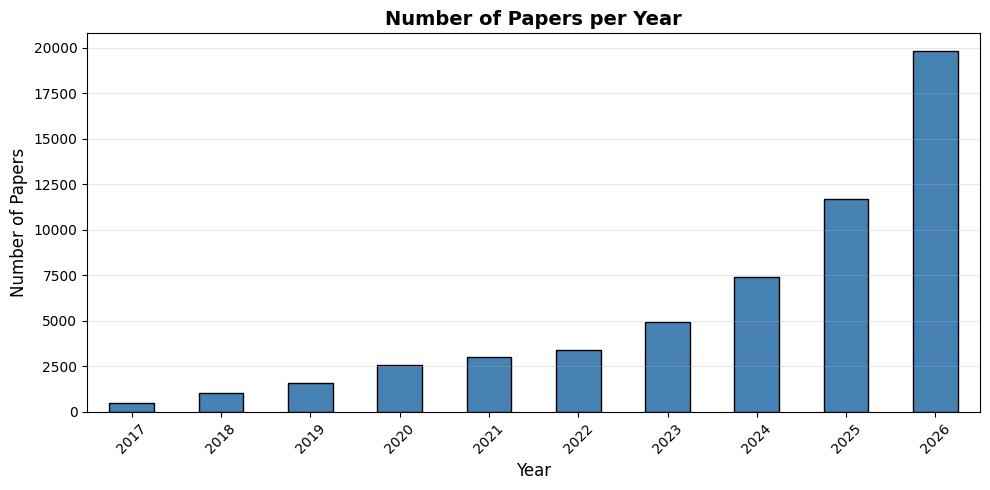

In [3]:
print("=" * 60)
print("PAPERS BY YEAR")
print("=" * 60)

if 'year' in df.columns:
    year_counts = df['year'].value_counts().sort_index()
    print("\nNumber of papers per year:")
    print(year_counts)
    print(f"\nTotal: {year_counts.sum():,} papers")
    print(f"\nYear range: {df['year'].min()} - {df['year'].max()}")
    
    # Visualize
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    year_counts.plot(kind='bar', color='steelblue', edgecolor='black')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Papers', fontsize=12)
    plt.title('Number of Papers per Year', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("'year' column not found in dataset")

In [4]:
print("=" * 60)
print("BASIC STATISTICS")
print("=" * 60)

print("\nFirst few rows:")
print(df.head())

print("\n" + "-" * 60)
print("\nDataFrame info:")
df.info()

BASIC STATISTICS

First few rows:
   year         id                                              title  \
0  2017  B1-Hhnslg        Prototypical Networks for Few-shot Learning   
1  2017  B1-q5Pqxl  Machine Comprehension Using Match-LSTM and Ans...   
2  2017  B16Jem9xe             Learning in Implicit Generative Models   
3  2017  B16dGcqlx                    Third Person Imitation Learning   
4  2017  B184E5qee  Improving Neural Language Models with a Contin...   

                                            abstract  \
0  A recent approach to few-shot classification c...   
1  Machine comprehension of text is an important ...   
2  Generative adversarial networks (GANs) provide...   
3  Reinforcement learning (RL) makes it possible ...   
4  We propose an extension to neural network lang...   

                                          authors author_ids  \
0        Jake Snell, Kevin Swersky, Richard Zemel              
1                       Shuohang Wang, Jing Jiang             

In [5]:
print("=" * 60)
print("ADDITIONAL ANALYSIS")
print("=" * 60)

# Check for decision column
if 'decision' in df.columns:
    print("\nDecision distribution:")
    decision_counts = df['decision'].value_counts()
    print(decision_counts)
    print(f"\nAcceptance rate (if 'Accept' in decisions):")
    if any('Accept' in str(d) for d in decision_counts.index):
        accept_cols = [d for d in decision_counts.index if 'Accept' in str(d)]
        accept_count = sum(decision_counts[d] for d in accept_cols)
        print(f"  Accepted: {accept_count:,} ({100*accept_count/len(df):.1f}%)")
        print(f"  Total: {len(df):,}")

# Check for scores column
if 'scores' in df.columns:
    print("\n" + "-" * 60)
    print("\nScore statistics:")
    # Calculate average scores for papers with scores
    avg_scores = []
    for scores in df['scores']:
        if isinstance(scores, list) and len(scores) > 0:
            avg_scores.append(np.mean(scores))
    
    if avg_scores:
        print(f"  Papers with scores: {len(avg_scores):,}")
        print(f"  Average score: {np.mean(avg_scores):.2f}")
        print(f"  Median score: {np.median(avg_scores):.2f}")
        print(f"  Min score: {np.min(avg_scores):.2f}")
        print(f"  Max score: {np.max(avg_scores):.2f}")

# Check abstract lengths
if 'abstract' in df.columns:
    print("\n" + "-" * 60)
    print("\nAbstract length statistics:")
    abstract_lengths = df['abstract'].str.len()
    print(f"  Mean length: {abstract_lengths.mean():.1f} characters")
    print(f"  Median length: {abstract_lengths.median():.1f} characters")
    print(f"  Min length: {abstract_lengths.min()} characters")
    print(f"  Max length: {abstract_lengths.max()} characters")

ADDITIONAL ANALYSIS

Decision distribution:
decision
                            19673
Reject                      17096
Withdrawn                    7594
Accept (Poster)              6173
Accept (poster)              1809
Accept: poster               1202
Accept (Spotlight)            775
Accept (Oral)                 383
Accept (spotlight)            366
Accept: notable-top-25%       280
Desk rejected                 194
Invite to Workshop Track      136
Accept: notable-top-5%         91
Accept (oral)                  86
Accept (Talk)                  48
Name: count, dtype: int64

Acceptance rate (if 'Accept' in decisions):
  Accepted: 11,213 (20.1%)
  Total: 55,906

------------------------------------------------------------

Score statistics:

------------------------------------------------------------

Abstract length statistics:
  Mean length: 1325.1 characters
  Median length: 1313.0 characters
  Min length: 108 characters
  Max length: 4999 characters


In [6]:
print("=" * 60)
print("SAMPLE DATA")
print("=" * 60)

# Show a few sample rows with key information
sample_cols = ['year', 'title', 'abstract'] if all(c in df.columns for c in ['year', 'title', 'abstract']) else df.columns[:5]
print(f"\nSample rows (showing columns: {', '.join(sample_cols)}):")
print(df[sample_cols].head(3).to_string())

SAMPLE DATA

Sample rows (showing columns: year, title, abstract):
   year                                                      title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [11]:
df['keywords']

0                       [deep learning, transfer learning]
1             [natural language processing, deep learning]
2                                  [unsupervised learning]
3                                                       []
4                            [natural language processing]
                               ...                        
55901    [deep neural networks, activation function lea...
55902    [diffusion models, distribution matching, dist...
55903                                   [sparse attention]
55904                [reinforcement learning, exploration]
55905            [large language models, persona modeling]
Name: keywords, Length: 55906, dtype: object

In [ ]:
df['labels'].unique() # all the unique areas in ICLR

array(['transfer learning', 'language models', 'unlabeled',
       'optimization', 'semi-supervised learning', 'RL',
       'multi-task learning', 'GANs', 'RNNs', 'clustering',
       'code generation', 'autoencoders', 'few-shot learning',
       'multi-agent RL', 'LLMs', 'neuroscience', 'compression',
       'continual learning', 'CNNs', 'speech', 'adversarial', 'privacy',
       'imitation learning', 'transformers', 'graphs', 'meta learning',
       'neural architecture search', 'robustness', 'optimal transport',
       'object detection', 'out-of-distribution', 'interpretability',
       'active learning', 'causality', 'pruning', 'safety',
       'model-based RL', 'fairness', 'knowledge graphs',
       'diffusion models', 'PDEs', 'alignment', 'anomaly detection',
       'time series', 'explainability', 'self-supervised learning',
       'knowledge distillation', 'federated learning', 'molecules',
       'autonomous driving', '3D scenes', 'offline RL', 'ViTs',
       'vision-language

In [14]:
print("=" * 60)
print("LABEL COUNTS")
print("=" * 60)

if 'labels' in df.columns:
    label_counts = df['labels'].value_counts().sort_values(ascending=False)
    print("\nCount of papers per label:")
    print(label_counts)
    print(f"\nTotal labels: {len(label_counts)}")
    print(f"Total papers: {label_counts.sum():,}")
    
    # Show percentages
    print("\n" + "-" * 60)
    print("\nLabel distribution (percentage):")
    label_pct = (df['labels'].value_counts(normalize=True) * 100).sort_values(ascending=False)
    for label, count in label_counts.items():
        pct = label_pct[label]
        print(f"  {label}: {count:,} ({pct:.2f}%)")
else:
    print("'labels' column not found in dataset")
    print(f"Available columns: {list(df.columns)}")

LABEL COUNTS

Count of papers per label:
labels
unlabeled                     25371
LLMs                           4116
RL                             2178
language models                1773
diffusion models               1749
graphs                         1404
optimization                   1382
adversarial                    1310
transformers                   1048
self-supervised learning        857
transfer learning               664
continual learning              567
federated learning              567
vision-language models          553
out-of-distribution             485
autoencoders                    459
causality                       454
GANs                            453
privacy                         451
time series                     439
safety                          438
interpretability                426
alignment                       411
explainability                  408
compression                     399
multi-agent RL                  390
meta learning   

In [36]:
print("=" * 60)
print("10 RANDOM OPTIMIZATION PAPERS FROM 2020")
print("=" * 60)

# Filter for optimization label and year 2020
optimization_2020 = df[(df['labels'] == 'optimization') & (df['year'] == 2020)]

print(f"\nTotal optimization papers from 2020: {len(optimization_2020)}")

if len(optimization_2020) > 0:
    # Sample 10 random papers (or all if less than 10)
    n_samples = min(10, len(optimization_2020))
    random_papers = optimization_2020.sample(n=n_samples, random_state=42)
    
    print(f"\nShowing {n_samples} random papers:\n")
    print("-" * 60)
    
    for idx, (i, row) in enumerate(random_papers.iterrows(), 1):
        print(f"\n{idx}. Paper ID: {row.get('id', 'N/A')}")
        print(f"   Title: {row.get('title', 'N/A')}")
        print(f"   Authors: {row.get('authors', 'N/A')[:200]}...")  # Truncate long author lists
        print(f"   Decision: {row.get('decision', 'N/A')}")
        if 'abstract' in row:
            abstract_preview = str(row['abstract'])[:200] + "..." if len(str(row['abstract'])) > 200 else str(row['abstract'])
            print(f"   Abstract: {abstract_preview}")
        print("-" * 60)
    
    # Also show as DataFrame for easier viewing
    print("\n\nAs DataFrame (showing key columns):")
    display_cols = ['id', 'year', 'title', 'authors', 'decision', 'labels']
    display_cols = [col for col in display_cols if col in random_papers.columns]
    print(random_papers[display_cols].to_string())
else:
    print("\nNo optimization papers found from 2020")
    print(f"Available labels: {df['labels'].unique()[:10]}")
    print(f"Available years: {sorted(df['year'].unique())}")

10 RANDOM OPTIMIZATION PAPERS FROM 2020

Total optimization papers from 2020: 80

Showing 10 random papers:

------------------------------------------------------------

1. Paper ID: HkgTTh4FDH
   Title: Implicit Bias of Gradient Descent based Adversarial Training on Separable Data
   Authors: Yan Li, Ethan X.Fang, Huan Xu, Tuo Zhao...
   Decision: Accept (Poster)
   Abstract: Adversarial training is a principled approach for training robust neural networks. Despite of tremendous successes in practice, its theoretical properties still remain largely unexplored. In this pape...
------------------------------------------------------------

2. Paper ID: B1erJJrYPH
   Title: Optimizing Loss Landscape Connectivity via Neuron Alignment
   Authors: N. Joseph Tatro, Pin-Yu Chen, Payel Das, Igor Melnyk, Prasanna Sattigeri, Rongjie Lai...
   Decision: Reject
   Abstract: The loss landscapes of deep neural networks are poorly understood due to their high nonconvexity. Empirically, the local opti

In [37]:
# Get the paper IDs from the previous cell
optimization_2020 = df[(df['labels'] == 'optimization') & (df['year'] == 2020)]
random_papers = optimization_2020.sample(n=min(10, len(optimization_2020)), random_state=42)
paper_ids = random_papers['id'].tolist()

print(f"Fetching reviews for {len(paper_ids)} papers:")
for pid in paper_ids:
    print(f"  - {pid}")

Fetching reviews for 10 papers:
  - HkgTTh4FDH
  - B1erJJrYPH
  - H1gEP6NFwr
  - Hklcm0VYDS
  - BygJKn4tPr
  - HkerqCEtvS
  - BJgnXpVYwS
  - rkgqN1SYvr
  - B1lxV6NFPH
  - BJlaG0VFDH


In [38]:
import openreview
import pandas as pd
import time

def get_value_api2(field):
    """Extract value from API v2 nested dict format (used by AutoReviewer)"""
    if isinstance(field, dict):
        return field.get('value', field)
    return field

def content_dict_to_text(content_dict):
    """Extract text from content dictionary"""
    main_keys = ["title", "summary", "strengths", "weaknesses", "questions", "comment", "metareview", "rating", "review"]
    text = ""
    for k in main_keys:
        data = content_dict.get(k)
        if data is None:
            continue
        # Handle both old format (direct value) and new format (dict with 'value')
        if isinstance(data, dict) and 'value' in data:
            text += f"\n{k}:\n{data['value']}\n"
        else:
            text += f"\n{k}:\n{str(data)}\n"
    return text.strip()

def get_reviews_for_paper(forum_id, year=2020):
    """
    Fetch reviews for a specific paper using OpenReview client (AutoReviewer approach).
    
    For 2020 (API v1): Uses openreview.Client
    For 2024+ (API v2): Uses openreview.api.OpenReviewClient
    """
    try:
        # Initialize appropriate client based on year (following AutoReviewer approach)
        if year < 2024:
            client = openreview.Client(baseurl='https://api.openreview.net')
        else:
            client = openreview.api.OpenReviewClient(baseurl='https://api2.openreview.net')
        
        # Get all notes in the forum (submission + all replies)
        # This is the proper way according to AutoReviewer
        notes = client.get_notes(forum=forum_id)
        
        reviews = []
        invitation_types = {}
        
        for note in notes:
            # Get invitation - API v1 uses 'invitation' (string attribute), API v2 uses 'invitations' (list attribute)
            if year < 2024:
                invitation = getattr(note, 'invitation', '')
                invitations = [invitation] if invitation else []
            else:
                invitations = getattr(note, 'invitations', [])
                invitation = invitations[0] if invitations else ''
            
            if invitation:
                inv_type = invitation.split("/")[-1]
                invitation_types[inv_type] = invitation_types.get(inv_type, 0) + 1
            
            # Check if it's an Official_Review (following AutoReviewer pattern)
            is_review = False
            if year < 2024:
                is_review = 'Official_Review' in invitation
            else:
                is_review = any('Official_Review' in inv for inv in invitations) if invitations else False
            
            if is_review:
                content = note.content if hasattr(note, 'content') else {}
                
                review_data = {
                    'paper_id': forum_id,
                    'review_id': note.id if hasattr(note, 'id') else '',
                    'review_type': inv_type if invitation else '',
                    'rating': None,
                    'summary': None,
                    'strengths': None,
                    'weaknesses': None,
                    'questions': None,
                    'comment': None,
                    'review': None,  # Full review text
                    'content': None,
                    'cdate': note.cdate if hasattr(note, 'cdate') else None,
                    'writer': note.signatures[0] if hasattr(note, 'signatures') and note.signatures else None,
                }
                
                # Extract fields - handle API v1 (direct) vs API v2 (nested) format
                if year < 2024:
                    # API v1: direct values
                    review_data['rating'] = content.get('rating', '')
                    review_data['review'] = content.get('review', '')
                    for field in ['summary', 'strengths', 'weaknesses', 'questions', 'comment', 'title']:
                        review_data[field] = content.get(field, '')
                else:
                    # API v2: nested {'value': ...} format
                    review_data['rating'] = get_value_api2(content.get('rating', ''))
                    review_data['review'] = get_value_api2(content.get('review', ''))
                    for field in ['summary', 'strengths', 'weaknesses', 'questions', 'comment', 'title']:
                        review_data[field] = get_value_api2(content.get(field, ''))
                
                # Get full content text for reference
                review_data['content'] = content_dict_to_text(content)
                
                reviews.append(review_data)
        
        # Debug output
        if len(reviews) == 0 and len(notes) > 0:
            print(f"  Found {len(notes)} notes but 0 reviews. Invitation types: {invitation_types}", end=' ')
        else:
            print(f"  Found {len(reviews)} reviews", end=' ')
        
        return reviews
    except Exception as e:
        print(f"  Error: {str(e)[:100]}", end=' ')
        return []

# Fetch reviews for all papers
all_reviews = []
print("Fetching reviews using AutoReviewer approach...")
print("=" * 60)

for i, paper_id in enumerate(paper_ids, 1):
    print(f"[{i}/{len(paper_ids)}] Fetching reviews for {paper_id}...", end=' ')
    try:
        reviews = get_reviews_for_paper(paper_id, year=2020)
        all_reviews.extend(reviews)
        print(f"✓")
    except Exception as e:
        print(f"✗ Error: {str(e)[:50]}")
    time.sleep(0.5)  # Small delay to avoid rate limiting (like AutoReviewer)

print(f"\n{'=' * 60}")
print(f"Total reviews fetched: {len(all_reviews)}")

# Create DataFrame
if all_reviews:
    reviews_df = pd.DataFrame(all_reviews)
    print(f"\nReviews DataFrame shape: {reviews_df.shape}")
    print(f"\nColumns: {list(reviews_df.columns)}")
    print(f"\nReviews per paper:")
    print(reviews_df['paper_id'].value_counts().sort_index())
else:
    print("\nNo reviews found!")
    reviews_df = pd.DataFrame()

Fetching reviews using AutoReviewer approach...
[1/10] Fetching reviews for HkgTTh4FDH...   Found 3 reviews ✓
[2/10] Fetching reviews for B1erJJrYPH...   Found 3 reviews ✓
[3/10] Fetching reviews for H1gEP6NFwr...   Found 2 reviews ✓
[4/10] Fetching reviews for Hklcm0VYDS...   Found 3 reviews ✓
[5/10] Fetching reviews for BygJKn4tPr...   Found 3 reviews ✓
[6/10] Fetching reviews for HkerqCEtvS...   Found 4 notes but 0 reviews. Invitation types: {'Desk_Reject': 1, 'Official_Comment': 1, 'Public_Comment': 1, 'Desk_Rejected_Submission': 1} ✓
[7/10] Fetching reviews for BJgnXpVYwS...   Found 3 reviews ✓
[8/10] Fetching reviews for rkgqN1SYvr...   Found 3 reviews ✓
[9/10] Fetching reviews for B1lxV6NFPH...   Found 3 reviews ✓
[10/10] Fetching reviews for BJlaG0VFDH...   Found 3 reviews ✓

Total reviews fetched: 26

Reviews DataFrame shape: (26, 14)

Columns: ['paper_id', 'review_id', 'review_type', 'rating', 'summary', 'strengths', 'weaknesses', 'questions', 'comment', 'review', 'content', 

In [39]:
# Display the reviews dataframe
if len(reviews_df) > 0:
    print("=" * 60)
    print("REVIEWS DATAFRAME")
    print("=" * 60)
    print(f"\nTotal reviews: {len(reviews_df)}")
    print(f"\nReviews per paper:")
    print(reviews_df['paper_id'].value_counts().sort_index())
    print(f"\n\nFirst few reviews:")
    print(reviews_df.head(10).to_string())
    
    # Show sample review content
    print("\n" + "=" * 60)
    print("SAMPLE REVIEW CONTENT")
    print("=" * 60)
    sample_review = reviews_df.iloc[0]
    print(f"\nPaper ID: {sample_review['paper_id']}")
    print(f"Review ID: {sample_review['review_id']}")
    print(f"Rating: {sample_review['rating']}")
    print(f"\nFull content:")
    if sample_review['content']:
        print(str(sample_review['content'])[:1000] + ("..." if len(str(sample_review['content'])) > 1000 else ""))
else:
    print("No reviews to display")

REVIEWS DATAFRAME

Total reviews: 26

Reviews per paper:
paper_id
B1erJJrYPH    3
B1lxV6NFPH    3
BJgnXpVYwS    3
BJlaG0VFDH    3
BygJKn4tPr    3
H1gEP6NFwr    2
HkgTTh4FDH    3
Hklcm0VYDS    3
rkgqN1SYvr    3
Name: count, dtype: int64


First few reviews:
     paper_id   review_id      review_type          rating summary strengths weaknesses questions comment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [40]:
import openreview
import pandas as pd
import time

def get_value_api2(field):
    """Extract value from API v2 nested dict format (used by AutoReviewer)"""
    if isinstance(field, dict):
        return field.get('value', field)
    return field

def content_dict_to_text(content_dict):
    """Extract text from content dictionary"""
    main_keys = ["title", "summary", "strengths", "weaknesses", "questions", "comment", "metareview", "rating", "review"]
    text = ""
    for k in main_keys:
        data = content_dict.get(k)
        if data is None:
            continue
        # Handle both old format (direct value) and new format (dict with 'value')
        if isinstance(data, dict) and 'value' in data:
            text += f"\n{k}:\n{data['value']}\n"
        else:
            text += f"\n{k}:\n{str(data)}\n"
    return text.strip()

def get_reviews_for_paper(forum_id, year=2020):
    """Fetch reviews for a specific paper using OpenReview client (like AutoReviewer)"""
    try:
        # Initialize appropriate client based on year
        if year < 2024:
            client = openreview.Client(baseurl='https://api.openreview.net')
        else:
            client = openreview.api.OpenReviewClient(baseurl='https://api2.openreview.net')
        
        # Get all notes in the forum (submission + all replies)
        # This is the proper way according to AutoReviewer
        notes = client.get_notes(forum=forum_id)
        
        reviews = []
        invitation_types = {}
        
        for note in notes:
            # Get invitation - API v1 uses 'invitation' (string), API v2 uses 'invitations' (list)
            if year < 2024:
                invitation = getattr(note, 'invitation', '')
            else:
                invitations = getattr(note, 'invitations', [])
                invitation = invitations[0] if invitations else ''
            
            if invitation:
                inv_type = invitation.split("/")[-1]
                invitation_types[inv_type] = invitation_types.get(inv_type, 0) + 1
            
            # Check if it's an Official_Review
            if year < 2024:
                is_review = 'Official_Review' in invitation
            else:
                is_review = any('Official_Review' in inv for inv in invitations) if invitations else False
            
            if is_review:
                content = note.content if hasattr(note, 'content') else {}
                
                review_data = {
                    'paper_id': forum_id,
                    'review_id': note.id if hasattr(note, 'id') else '',
                    'review_type': inv_type if invitation else '',
                    'rating': None,
                    'summary': None,
                    'strengths': None,
                    'weaknesses': None,
                    'questions': None,
                    'comment': None,
                    'review': None,  # Full review text
                    'content': None,
                    'cdate': note.cdate if hasattr(note, 'cdate') else None,
                    'writer': note.signatures[0] if hasattr(note, 'signatures') and note.signatures else None,
                }
                
                # Extract fields - handle API v2 nested format
                if year < 2024:
                    # API v1: direct values
                    review_data['rating'] = content.get('rating', '')
                    review_data['review'] = content.get('review', '')
                    for field in ['summary', 'strengths', 'weaknesses', 'questions', 'comment', 'title']:
                        review_data[field] = content.get(field, '')
                else:
                    # API v2: nested {'value': ...} format
                    review_data['rating'] = get_value_api2(content.get('rating', ''))
                    review_data['review'] = get_value_api2(content.get('review', ''))
                    for field in ['summary', 'strengths', 'weaknesses', 'questions', 'comment', 'title']:
                        review_data[field] = get_value_api2(content.get(field, ''))
                
                # Get full content text for reference
                review_data['content'] = content_dict_to_text(content)
                
                reviews.append(review_data)
        
        # Debug output
        if len(reviews) == 0 and len(notes) > 0:
            print(f"  Found {len(notes)} notes but 0 reviews. Invitation types: {invitation_types}", end=' ')
        else:
            print(f"  Found {len(reviews)} reviews", end=' ')
        
        return reviews
    except Exception as e:
        print(f"  Error: {str(e)[:50]}", end=' ')
        return []

# Fetch reviews for all papers
all_reviews = []
print("Fetching reviews...")
for i, paper_id in enumerate(paper_ids, 1):
    print(f"[{i}/{len(paper_ids)}] Fetching reviews for {paper_id}...", end=' ')
    try:
        reviews = get_reviews_for_paper(paper_id, year=2020)
        all_reviews.extend(reviews)
        print(f"Found {len(reviews)} reviews")
    except Exception as e:
        print(f"Error: {str(e)[:50]}")
    time.sleep(0.5)  # Small delay to avoid rate limiting (like AutoReviewer)

print(f"\nTotal reviews fetched: {len(all_reviews)}")

# Create DataFrame
if all_reviews:
    reviews_df = pd.DataFrame(all_reviews)
    print(f"\nReviews DataFrame shape: {reviews_df.shape}")
    print(f"\nColumns: {list(reviews_df.columns)}")
else:
    print("\nNo reviews found!")
    reviews_df = pd.DataFrame()

Fetching reviews...
[1/10] Fetching reviews for HkgTTh4FDH...   Found 3 reviews Found 3 reviews
[2/10] Fetching reviews for B1erJJrYPH...   Found 3 reviews Found 3 reviews
[3/10] Fetching reviews for H1gEP6NFwr...   Found 2 reviews Found 2 reviews
[4/10] Fetching reviews for Hklcm0VYDS...   Found 3 reviews Found 3 reviews
[5/10] Fetching reviews for BygJKn4tPr...   Found 3 reviews Found 3 reviews
[6/10] Fetching reviews for HkerqCEtvS...   Found 4 notes but 0 reviews. Invitation types: {'Desk_Reject': 1, 'Official_Comment': 1, 'Public_Comment': 1, 'Desk_Rejected_Submission': 1} Found 0 reviews
[7/10] Fetching reviews for BJgnXpVYwS...   Found 3 reviews Found 3 reviews
[8/10] Fetching reviews for rkgqN1SYvr...   Found 3 reviews Found 3 reviews
[9/10] Fetching reviews for B1lxV6NFPH...   Found 3 reviews Found 3 reviews
[10/10] Fetching reviews for BJlaG0VFDH...   Found 3 reviews Found 3 reviews

Total reviews fetched: 26

Reviews DataFrame shape: (26, 14)

Columns: ['paper_id', 'review_i

In [44]:
# Display the reviews dataframe
if len(reviews_df) > 0:
    print("=" * 60)
    print("REVIEWS DATAFRAME")
    print("=" * 60)
    print(f"\nTotal reviews: {len(reviews_df)}")
    print(f"\nReviews per paper:")
    print(reviews_df['paper_id'].value_counts())
    print(f"\n\nFirst few reviews:")
    print(reviews_df.head(10).to_string())
    
    # Show sample review content
    if len(reviews_df) > 0:
        print("\n" + "=" * 60)
        print("SAMPLE REVIEW CONTENT")
        print("=" * 60)
        sample_review = reviews_df.iloc[0]
        print(f"\nPaper ID: {sample_review['paper_id']}")
        print(f"Review ID: {sample_review['review_id']}")
        print(f"Rating: {sample_review['rating']}")
        print(f"\nContent preview:")
        if sample_review['content']:
            print(str(sample_review['content'])[:500] + "...")
else:
    print("No reviews to display")

REVIEWS DATAFRAME

Total reviews: 26

Reviews per paper:
paper_id
HkgTTh4FDH    3
B1erJJrYPH    3
Hklcm0VYDS    3
BygJKn4tPr    3
BJgnXpVYwS    3
B1lxV6NFPH    3
rkgqN1SYvr    3
BJlaG0VFDH    3
H1gEP6NFwr    2
Name: count, dtype: int64


First few reviews:
     paper_id   review_id      review_type          rating summary strengths weaknesses questions comment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
# https://huggingface.co/datasets/skonan/iclr-reviews-2020-2026

# TODO a join of these with the parquet file of iclr-datasets to see common paper ids